In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


## Wybór optymalnych punktów charakterystycznych

In [3]:
import numpy as np

LANDMARK_INDEXES = np.load(os.path.join('..', '..', 'data', 'landmarks', 'combined_selected_points_smile.npy'))
REFERENCE_POINT_IDX = 0

### Wizualizacja wybranych punktów

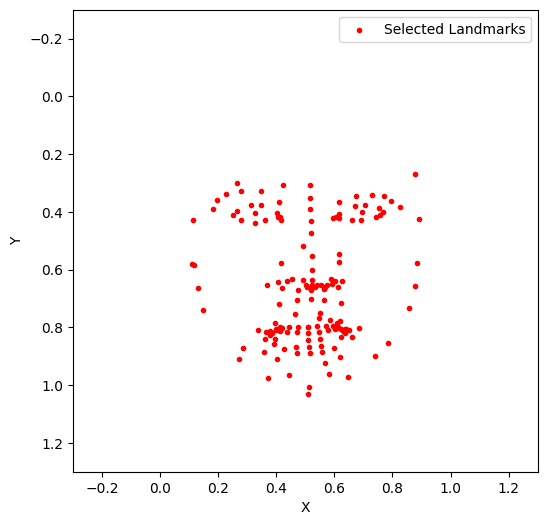

In [4]:
from utils import visualize_landmarks

visualize_landmarks(LANDMARK_INDEXES)

### Zdobycie danych

In [6]:
from utils import load_data, convert_landmarks_to_distances

all_data, all_labels = load_data('nemo_smile')
all_data = convert_landmarks_to_distances(all_data, LANDMARK_INDEXES, REFERENCE_POINT_IDX, normalize=True)

## Preprocessing danych

In [7]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels, binarize_labels=False)

In [8]:
print(X_train.shape)
print(y_train.shape)

torch.Size([868, 609, 154])
torch.Size([868])


In [9]:
from utils import get_class_distribution

get_class_distribution(all_labels)

===> Class distribution <===
0: 597
1: 643
=============><=============


# MODEL TORCH

### W podejściu wykorzystane zostaną 2 modele - pierwszy z nich będzie siecią konwolucyjną 2d, która będzie miała za zadanie nauczyć się rozpoznawać cechy charakterystyczne dla wybranej klatki (zbioru współrzędnych pkt charakterystycznych). Do klasyfikacji szeregu czasowego zostanie wykorzystana sekwencyjna sieć neuronowa LSTM.

## Zbudowanie modelu ekstrakcji cech

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SmileClassifier(nn.Module):
    def __init__(self, input_distances):
        super(SmileClassifier, self).__init__()
        
        # Spatial feature extraction (changed in_channels to 1)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate LSTM input dimension
        self.conv_output_size = 64 * (input_distances // 4)  # After two poolings
        
        # Temporal feature extraction
        self.lstm = nn.LSTM(input_size=self.conv_output_size, hidden_size=128,
                          batch_first=True, bidirectional=True)
        
        # Classification head
        self.attn = nn.Linear(256, 1)
        self.fc1 = nn.Linear(256, 64)  # 128*2 for bidirectional
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.1)

    def forward(self, x):
        # x shape: (batch_size, frames, distances)
        batch_size, frames, distances = x.shape
        
        # Reshape for Conv1D: (batch*frames, 1, distances)
        x = x.view(-1, 1, distances)
        
        # Spatial features
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Prepare for LSTM
        x = x.view(batch_size, frames, -1)
        
        # Temporal features
        x, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = (x * attn_weights).sum(dim=1)
        
        # Classification head (remove sigmoid!)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)  # Raw logits

In [ ]:
from torch.optim import Adam

model = SmileClassifier(input_distances=len(LANDMARK_INDEXES))
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam(model.parameters(), lr=1e-4)

### Diagnostyka

In [17]:
from torch.utils.tensorboard import SummaryWriter

RUNS_FOLDER_PATH = os.path.abspath('runs')
writer_diag_path = os.path.join('runs', 'torch_lstm', 'lie_classifier_landmark_distance_normalized_overfit')
writer_diag = SummaryWriter(writer_diag_path)

In [ ]:
from utils.model_functions import overfit_model

model_diag = SmileClassifier(input_distances=len(LANDMARK_INDEXES))
criterion_diag = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_diag = Adam(model.parameters(), lr=1e-3)

overfit_model(model_diag, criterion_diag, optimizer_diag, X_train, y_train, batch_size=1, prediction_threshold=0.5, writer=writer_diag, epochs=2000)

## Trening modelu

In [ ]:
writer_path = os.path.join('runs', 'torch_lstm', 'lie_classifier_landmark_distance_normalized')
writer = SummaryWriter(writer_path)

In [ ]:
from utils.model_functions import train_torch_model_binary

train_torch_model_binary(model, criterion, optimizer, X_train, y_train, X_val, y_val, unbalanced=True, writer=writer, prediction_threshold=0.5)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                     TRAINING                                         VALIDATION                    
----------------------------------------------------------------------------------------------------
Loss        : 17.464465                                    Loss        : 3.796686
Accuracy    : 0.5588                                    Accuracy    : 0.5914
Precision   : 0.5708                                    Precision   : 0.7725
Recall      : 0.5620                                    Recall      : 0.6000
F1 Score    : 0.5461                                    F1 Score    : 0.5194
----------------------------------------------------------------------------------------------------
                                          VALIDATION EXTRA                              

## Ewaluacja modelu

In [15]:
from utils.model_functions import eval_torch_model_binary

eval_torch_model_binary(model, criterion, X_test, y_test)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                                             VALIDATION                                             
----------------------------------------------------------------------------------------------------
Loss        : 4.077794
Accuracy    : 0.7097
Precision   : 0.7118
Recall      : 0.7054
F1 Score    : 0.7056
----------------------------------------------------------------------------------------------------
                                          VALIDATION EXTRA                                          
TP Rate     : 0.6250                                    FP Rate     : 0.2143



# TODYNET

### Przygotowanie danych

In [10]:
X_train_np = X_train.numpy()
X_val_np = X_val.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy()
y_val_np = y_val.numpy()
y_test_np = y_test.numpy()

In [13]:
TodyNet_DATA_PATH = os.path.join("..", "..", "src", "external", "TodyNet", "data", "UCR", "NEMO_SMILE_NORMALIZED")

os.makedirs(TodyNet_DATA_PATH, exist_ok=True)

In [15]:
import torch

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(1)  # adding channel dimension
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(1)

# Save the data in PyTorch (.pt) format
torch.save(X_train_tensor, os.path.join(TodyNet_DATA_PATH, 'X_train.pt'))
torch.save(X_val_tensor, os.path.join(TodyNet_DATA_PATH, 'X_valid.pt'))
torch.save(X_test_tensor, os.path.join(TodyNet_DATA_PATH, 'X.pt'))

# Save the labels in PyTorch (.pt) format
torch.save(y_train.long(), os.path.join(TodyNet_DATA_PATH, 'y_train.pt'))
torch.save(y_val.long(), os.path.join(TodyNet_DATA_PATH, 'y_valid.pt'))
torch.save(y_test.long(), os.path.join(TodyNet_DATA_PATH, 'y.pt'))

### Trening modelu Zmiejszone parametry ze względu na wielkość modelu

In [ ]:
# cd .\src\external\TodyNet\src\ & python train.py --dataset='NEMO_SMILE_NORMALIZED' --num_layers 1 --in_dim 16 --hidden_dim 16 --out_dim 16 --pool_ratio 0.0 --kern_size "3" --groups 1

## Najlepszy wynik

TRAIN, epoch 14, loss 0.5032443579990193, acc tensor([77.0737], device='cuda:0')

VAL, loss 0.5627136839333401, acc tensor([73.1183], device='cuda:0')